In [85]:
%reload_ext autoreload
%matplotlib inline

In [3]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
import datetime as dt


from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings
import pickle
from scipy.interpolate import interp1d


#-- Own settings

from settings import *

## current script object
thismodule = sys.modules[__name__]
workdir = os.getcwd()
# Add own module library to path
moduledir, fcndir = defineDir(workdir)

# load own libraries
from conditionalstats import *
from conditionalstats_chunked import *
import plot1D as p1d
from casestudy import *


# own DYAMOND functions
from fcns_load_DYAMOND_SAM import *
# own TOOCAN functions
from load_TOOCAN_DYAMOND_modif_BF import load_TOOCAN_DYAMOND

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy', 'settings', 'fcns_load_RCEMIP_SAM']


In [139]:
figdir = os.path.join(os.path.dirname(workdir),'figures/test_theory')
os.makedirs(figdir,exist_ok=True)

# Pacific ITCZ

1. Distribution de pluie (au cours du temps)
2. Distribution de pluie conditionnée (à TOOCAN, en fonction du temps)
3. Pente des distributions
4. Fréquence d'occurrence des systèmes (en fonction du temps)
5. 

In [4]:
path_dy = '/data/bfildier/DYAMOND_REGIONS/205E_250E_0N_20N/SAM/'
path_dy_2D = os.path.join(path_dy,'2D')

In [5]:
regions = [regionNameFromCoord(box) for box in [box_1,box_2,box_3]]+['tropics']
masks = ['all','TOOCAN','PW_40']
varids = 'pr','PW'
varids_DY = 'Prec','PW'
i_t_0 = 832
i_t_end = 1917

In [6]:
###---- Load precomputed distributions

save_dir = os.path.join(DIR_OUT,'DYAMOND_case_studies')
os.makedirs(save_dir,exist_ok=True)

#- computation
compute_again = False

# load from disk
if not compute_again:

    dict_cs = pickle.load(open(os.path.join(save_dir,'dict_case_studies_all_regions.pickle'),'rb'))

# compute
if compute_again:

    dict_cs = {}

    for region in regions:
        
        print()
        print('**-- %s --**'%region)
        print()

        # init regional case study
        cs = CaseStudy(name='DYAMOND-SAM',
                           region=region,
                           rel_tab_dyam_seg=loadRelTable('DYAMOND_SEG'))

        # geographical parameters
        if region == 'tropics':
            lon_slice = slice(None,None)
            lat_slice = slice(-30,30)
        else:
            reg_coords = regionCoordsFromName(region)
            lon_slice = slice(reg_coords[0]%360,reg_coords[1]%360)
            lat_slice = slice(reg_coords[2],reg_coords[3])

        cs.setSimulationSpecs(i_t_min = 832,
                                      i_t_max = 1917,
                                      lat_slice=lat_slice,
                                      lon_slice=lon_slice)

        # load and compute distributions
        print('Load all time distributions')
        for varid in 'Prec','PW':

            print(varid)

            for mask in 'all','PW_40','TOOCAN','TOOCAN_PW_40':

                if varid == 'PW' and mask == 'TOOCAN_PW_40':
                    continue
                
                print('-',mask)

                # where sliced distributions are stored
                cs.setDirectories(region,varid,mask)

                # load all distributions
                cs.loadDistSliced(varid,mask)

        # compute mean precip time series
        cs.computeMean(varid='Prec',mask='all')

        # compute mean (time series) of PW above 40mm
        cs.computeMean(varid='PW',mask='PW_40')

        # find "missing" time indices
        cs.findTimeIndToIgnore()
        
        # store times
        cs.storeTimes()

        # compute full distributions
        print('compute full distributions')
        for varid in 'Prec','PW':

            print(varid)

            for mask in 'all','PW_40','TOOCAN','TOOCAN_PW_40':

                if varid == 'PW' and mask == 'TOOCAN_PW_40':
                    continue

                print('-',mask)
                cs.combineDistributions(varid,mask)

        # save
        dict_cs[region] = cs

    # save on disk
    pickle.dump(dict_cs,open(os.path.join(save_dir,'dict_case_studies_all_regions.pickle'),'wb'))



**-- 310E_340E_0N_20N --**

Load all time distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN
compute full distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN

**-- 205E_250E_0N_20N --**

Load all time distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN
compute full distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN

**-- 130E_165E_0N_20N --**

Load all time distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN
compute full distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN

**-- tropics --**

Load all time distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN
compute full distributions
Prec
- all
- PW_40
- TOOCAN
- TOOCAN_PW_40
PW
- all
- PW_40
- TOOCAN


In [7]:
save_dir

'../results/DYAMOND_case_studies'

In [8]:
! ls ../results/DYAMOND_case_studies

dict_case_studies_all_regions.pickle


In [7]:
# # Load precomputed distributions

# dict_distribs = {}

# for region in regions:
    
#     # init
#     dict_distribs[region] = {}

#     for varid,varid_DY in zip(varids,varids_DY):

#         # init
#         dict_distribs[region][varid] = {}
        
#         for mask in masks:
            
#             print(region,varid,mask)
            
#             # init
#             dict_distribs[region][varid][mask] = {}
            
#             for i_t in np.arange(i_t_0,i_t_end+1):
                
#                 if i_t%100 == 0 or i_t in [i_t_0,i_t_end]:
#                     print(i_t,end='..')
                
#                 filename = '../results/%s/%s/%s/time_slices/dist_%s_t_%d.pickle'%(region,varid_DY,mask,varid,i_t)

#                 # load if exists
#                 if len(glob.glob(filename)) > 0:
                    
#                     dict_distribs[region][varid][mask][i_t] = pickle.load(open(filename,'rb'))
                
#             print()

1. Distribution de pluie (au cours du temps)
2. Distribution de pluie conditionnée (à TOOCAN, en fonction du temps)

In [61]:
# regions of interest
warm_pool = '130E_165E_0N_20N'
eastern_pacific = '205E_250E_0N_20N'
atlantic = '310E_340E_0N_20N'

slope alpha, all: -15.600796644985476
slope alpha, R: -15.390332027386451


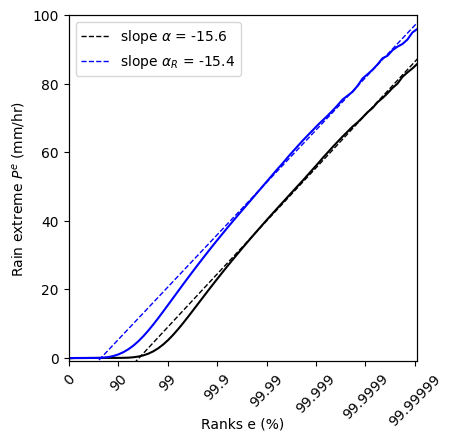

In [161]:
# Show distributions

region = warm_pool

# Full
dist_all = dict_cs[region].dist_pr_all
# in Region
# dist_R = dict_cs[region].dist_pr_PW_40
dist_R = dict_cs[region].dist_pr_TOOCAN

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

ranks = dist_all.ranks
rankmax = 99.99999
perc_all = dist_all.percentiles
perc_R = dist_R.percentiles

# -- fit of distributions
s_fit = slice(30,70)
x = np.log10(1-ranks/100)
y_all = perc_all
y_R = perc_R

# mask
def func(x,a,b):
    return a * x + b
popt_all, pcov = curve_fit(func,x[s_fit],y_all[s_fit])
popt_R, pcov = curve_fit(func,x[s_fit],y_R[s_fit])
alpha_all = popt_all[0]
alpha_WP = popt_R[0]
print('slope alpha, all:',popt_all[0])
print('slope alpha, R:',popt_R[0])

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
p1d.showData(ax,ranks,perc_all, c='k',rankmin=0, rankmax = rankmax)
p1d.showData(ax,ranks,perc_R, c='b',rankmin=0, rankmax = rankmax)

p1d.showData(ax,ranks,func(x,*popt_all), c='k',linestyle='--',linewidth=1,rankmin=0, rankmax = rankmax,label=r'slope $\alpha$ = %2.1f'%popt_all[0])
p1d.showData(ax,ranks,func(x,*popt_R), c='b',linestyle='--',linewidth=1,rankmin=0, rankmax = rankmax,label=r'slope $\alpha_R$ = %2.1f'%popt_R[0])

# legend
ax.legend()

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel('Rain extreme $P^e$ (mm/hr)')

ax.set_ylim((-1,100))

plt.savefig(os.path.join(figdir,'dist_P_PR_%s.pdf'%region),bbox_inches='tight')

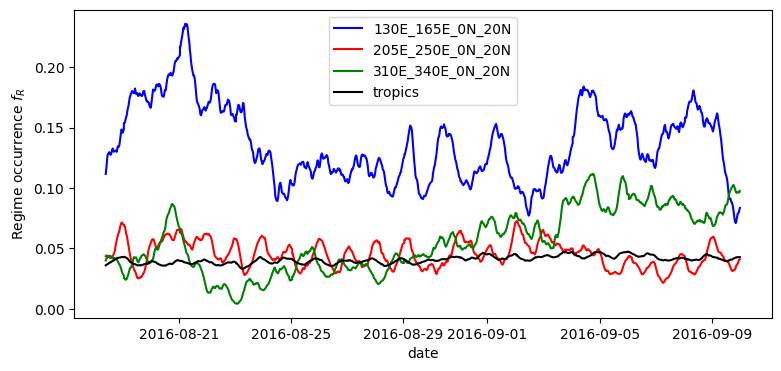

In [170]:
# Time variation of f_R

regions = '130E_165E_0N_20N','205E_250E_0N_20N','310E_340E_0N_20N','tropics'
maskid = 'TOOCAN'
cols = 'blue','red','green','k'
varid = 'Prec'

fig,ax = plt.subplots(figsize=(9,4))
    
for region,col in zip(regions,cols):
    
    # time
    time = dict_cs[region].time

    # fraction
    time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
    frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])

    ax.plot(time,frac_over_time,c=col,label=region)
    
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)

ax.legend()
    
ax.set_xlabel('date')
ax.set_ylabel(r'Regime occurrence $f_R$')

plt.savefig(os.path.join(figdir,'fR_t_all_regions.pdf'),bbox_inches='tight')

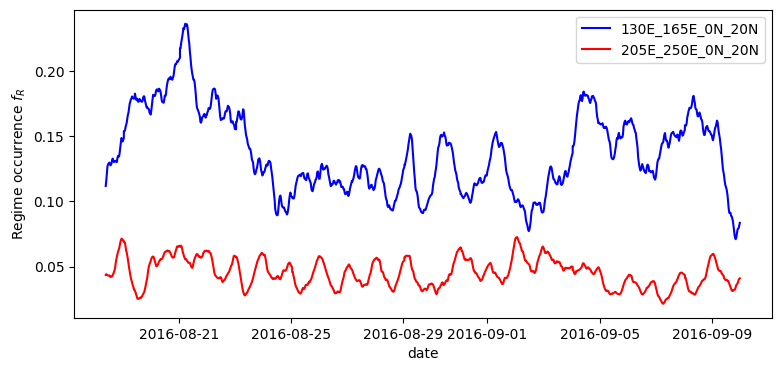

In [171]:
# Time variation of f_R

regions = '130E_165E_0N_20N','205E_250E_0N_20N'
maskid = 'TOOCAN'
cols = 'blue','red'
varid = 'Prec'

fig,ax = plt.subplots(figsize=(9,4))
    
for region,col in zip(regions,cols):
    
    # time
    time = dict_cs[region].time

    # fraction
    time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
    frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])

    ax.plot(time,frac_over_time,c=col,label=region)
    
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)

ax.legend()
    
ax.set_xlabel('date')
ax.set_ylabel(r'Regime occurrence $f_R$')

plt.savefig(os.path.join(figdir,'fR_t_all_WP_EP.pdf'),bbox_inches='tight')

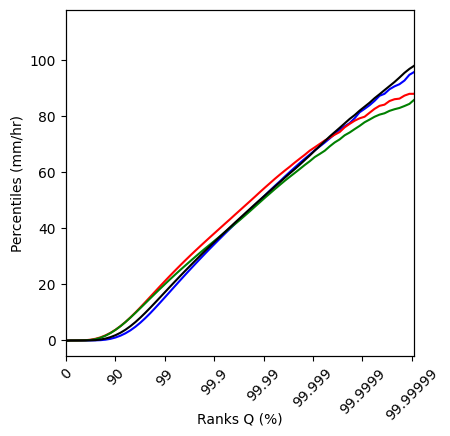

In [21]:
# Rain dsitribution over all regions

regions = '130E_165E_0N_20N','310E_340E_0N_20N','205E_250E_0N_20N','tropics'
maskid = 'TOOCAN'
cols = 'blue','red','green','k'
varid = 'pr'

dist_all = dict_cs[region].dist_pr_all
ranks = dist_all.ranks
rankmax = 99.99999

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

for region,col in zip(regions,cols):
    
    dist = getattr(dict_cs[region],'dist_%s_%s'%(varid,maskid))


    perc = dist.percentiles

    #- show data
    p1d.showData(ax,ranks,perc,c=col,rankmin=0, rankmax = rankmax)

    #- labels
    ax.set_xlabel('Ranks Q (%)',labelpad=40)
    ax.set_ylabel('Percentiles (mm/hr)')

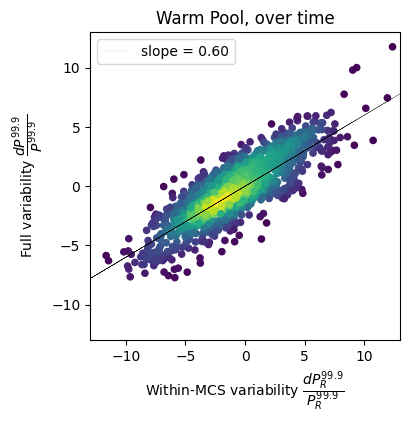

In [140]:
# Show variability of dPext vs dPext_R for regions with small fR variability

from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

# region = 'tropics'
region = '130E_165E_0N_20N'
# region = '205E_250E_0N_20N'
# region = '310E_340E_0N_20N'

rank_e = 99.9

def getDelta(dist,dist_times,rank_e):
    
    # rank index
    i_e = dist.indexOfRank(rank_e)
    # full distrib percentile
    pr_e = dist.percentiles[i_e]
    # anomalies
    dpr_ext = np.array([d.percentiles[i_e] - pr_e for d in dist_times.values()])
    
    return dpr_ext

# x -- conditioned on TOOCAN

mask = 'TOOCAN'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
dist_times = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%mask)
x = getDelta(dist,dist_times,rank_e)

# y -- full

mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
dist_times = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%mask)
y = getDelta(dist,dist_times,rank_e)

# z -- density

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

#-- fit

# mask
keep = np.logical_and(np.logical_and(x<10,x>-10),np.logical_and(y<10,y>-10))
def func(x, a):
    return a * x
popt, pcov = curve_fit(func,x[keep],y[keep])


#-- show

fig,ax = plt.subplots(figsize=(4,4))
# points
ax.scatter(x,y,c=z,s=20)
# fit
ax.plot(x, func(x, *popt),'k',linestyle=':',linewidth=0.1,label='slope = %1.2f'%popt[0])
# legend
ax.legend()

ax.set_xlim((-13,13))
ax.set_ylim((-13,13))
# ax.set_title('Eastern Pacific ITCZ')
ax.set_xlabel(r'Within-MCS variability $\dfrac{dP_R^{%2.1f}}{P_R^{%2.1f}}$'%(rank_e,rank_e))
ax.set_ylabel(r'Full variability $\dfrac{dP^{%2.1f}}{P^{%2.1f}}$'%(rank_e,rank_e))
ax.set_title('Warm Pool, over time')

plt.savefig(os.path.join(figdir,'time_var_dP_dPR_%s.pdf'%region),bbox_inches='tight')

Calculate $f^{R|e}$ coefficient to compare:

$$f^{R|e} = \frac{f^{e|R}f_R}{f^e}$$

In [143]:
# Same parameters as plot above
region = warm_pool
rank_e = 99.9

# f^{e|R} = percentile of rain of rank e within masked area R
mask = 'TOOCAN'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
i_e = dist.indexOfRank(rank_e)
f_e_R = dist.percentiles[i_e]/100
print(r'$f^{e|R}$ =',f_e_R)

# f_R
frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])
f_R = np.mean(frac_over_time)
print(r'$f_R$ =',f_R)

# f^e = percentile of rain of rank e within region
mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
i_e = dist.indexOfRank(rank_e)
f_e = dist.percentiles[i_e]/100
print(r'$f^e$ =',f_e)

# Resulting f^{R|e}
f_R_e = f_e_R*f_R/f_e
print(r'$f^{R|e}$ =',f_R_e)

$f^{e|R}$ = 0.34665183231234553
$f_R$ = 0.040769452141009896
$f^e$ = 0.233791412061546
$f^{R|e}$ = 0.060450489444544155


In [118]:
x,func(x,*popt)

(array([-0.34092591,  1.32751065,  4.60171212, ..., -0.49018622,
         1.37313137, -4.20788874]),
 array([-0.21796295,  0.84871269,  2.94199633, ..., -0.31338902,
         0.87787922, -2.69021461]))

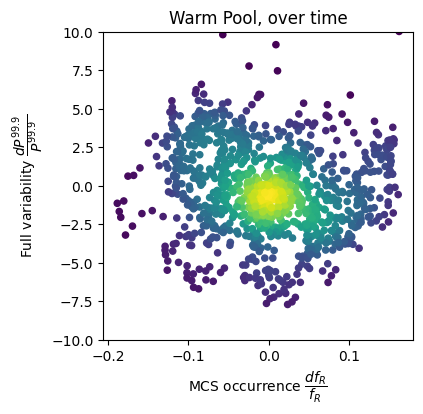

In [141]:
# Show variability of dPext vs df_R for regions with large fR variability

from scipy.stats import gaussian_kde

# region = 'tropics'
region = '130E_165E_0N_20N'
# region = '205E_250E_0N_20N'
# region = '310E_340E_0N_20N'

rank_e = 99.9

def getDelta(dist,dist_times,rank_e):
    
    # rank index
    i_e = dist.indexOfRank(rank_e)
    # full distrib percentile
    pr_e = dist.percentiles[i_e]
    # anomalies
    dpr_ext = np.array([d.percentiles[i_e] - pr_e for d in dist_times.values()])
    
    return dpr_ext


# x -- dfR/fR

frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])
frac_mean = np.mean(frac_over_time)
x = (frac_over_time - frac_mean)/frac_mean

# y -- full dP/P

mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
dist_times = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%mask)
y = getDelta(dist,dist_times,rank_e)


# z -- density

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fit



#-- show
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,c=z,s=20)
# ax.set_xlim((-8,8))
ax.set_ylim((-10,10))
# ax.set_title('Eastern Pacific ITCZ')
ax.set_ylabel(r'Full variability $\dfrac{dP^{%2.1f}}{P^{%2.1f}}$'%(rank_e,rank_e))
ax.set_xlabel(r'MCS occurrence $\dfrac{df_R}{f_R}$')
ax.set_title('Warm Pool, over time')

plt.savefig(os.path.join(figdir,'time_var_dP_dfR_%s.pdf'%region),bbox_inches='tight')

In [ ]:
# Show variability of dPext vs dPext_R and df_R in 3D plot.



In [11]:
# Calculate frequencies



In [31]:
# Calculate distribution slopes



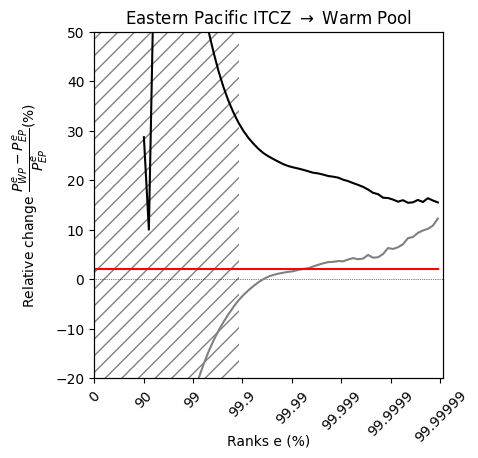

In [198]:
# Change in percentile from Warm Pool to Eastern Pacific



# ranks
dist_all = dict_cs[warm_pool].dist_pr_all
Npts = 70
s_ranks = slice(0,Npts)
ranks = dist_all.ranks[s_ranks]

def getPrChange(mask):

    # distributions
    perc_WP = getattr(dict_cs[warm_pool],'dist_pr_%s'%mask).percentiles[s_ranks]
    perc_EP = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%mask).percentiles[s_ranks]

    # relative change 
    dP_P = (perc_WP-perc_EP)/perc_EP*100
    
    # replace first decade with nans
    dP_P[:10] = np.nan
    
    return dP_P

# 1. dP/P

dP_P_all = getPrChange('all')

# 2. dP_R/P_R

dP_P_TOOCAN = getPrChange('TOOCAN')

# 3. dfR/fR
time_dist_WP = getattr(dict_cs[warm_pool],'dict_dist_pr_%s_sliced'%maskid)
frac_over_time_WP = np.array([time_dist_WP[i_t].frac for i_t in dict_cs[warm_pool].range_t])
f_WP = np.mean(frac_over_time_WP)

time_dist_EP = getattr(dict_cs[eastern_pacific],'dict_dist_pr_%s_sliced'%maskid)
frac_over_time_EP = np.array([time_dist_EP[i_t].frac for i_t in dict_cs[eastern_pacific].range_t])
f_EP = np.mean(frac_over_time_EP)

dfR_fR = np.full(Npts,(f_WP - f_EP)/f_EP)

#-- show

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
ax.axhline(y=0,linestyle=':',c='k',linewidth=0.5)
p1d.showData(ax,ranks,dP_P_all,c='k',rankmin=0, rankmax = rankmax)
p1d.showData(ax,ranks,dP_P_TOOCAN,c='grey',rankmin=0, rankmax = rankmax)
p1d.showData(ax,ranks,dfR_fR,c='r',rankmin=0, rankmax = rankmax)
p1d.addXHatch(ax,ranks,[0,29])

ax.set_ylim((-20,50))

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel(r'Relative change $\dfrac{P^e_{WP}-P^e_{EP}}{P^e_{EP}}$(%)')
ax.set_title(r'Eastern Pacific ITCZ $\rightarrow$ Warm Pool')

plt.show()

$f^{e|R}$ = [-7.34816939e-04 -4.99255955e-05 -1.00478530e-06  4.79160249e-05
  1.45757645e-04  2.92520076e-04  4.88203317e-04  1.17309466e-03
  2.88532302e-03  5.91841325e-03  1.06148110e-02  1.71701993e-02
  2.56824197e-02  3.62493165e-02  4.90176453e-02  6.37428127e-02
  8.01312821e-02  9.78895365e-02  1.16675128e-01  1.36047763e-01
  1.55762855e-01  1.75575782e-01  1.95437634e-01  2.15152718e-01
  2.34672118e-01  2.53946918e-01  2.73026034e-01  2.91811625e-01
  3.10425986e-01  3.28746863e-01  3.46651832e-01  3.64434569e-01
  3.82168377e-01  3.99412948e-01  4.16548295e-01  4.33460717e-01
  4.50454078e-01  4.67366548e-01  4.84521737e-01  5.01434179e-01
  5.18346629e-01  5.35420922e-01  5.52252434e-01  5.68315211e-01
  5.85632255e-01  6.02018724e-01  6.18121925e-01  6.34022892e-01
  6.49236004e-01  6.64004072e-01  6.79176653e-01  6.92933232e-01
  7.06851592e-01  7.21579117e-01  7.37075478e-01  7.53785616e-01
  7.64952681e-01  7.76119759e-01  7.93598638e-01  8.14961713e-01
  8.27261689e

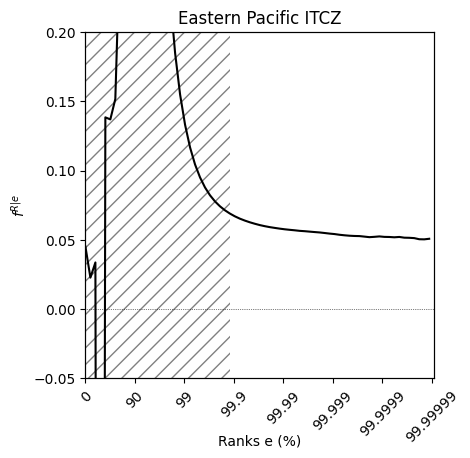

In [187]:
# show f_R_e vs percentile rank

# Same parameters as plot above
region = warm_pool
s_ranks = slice(0,70)

# f^{e|R} = percentile of rain of rank e within masked area R
mask = 'TOOCAN'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
f_e_R = dist.percentiles[s_ranks]/100
print(r'$f^{e|R}$ =',f_e_R)

# f_R
frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])
f_R = np.mean(frac_over_time)
print(r'$f_R$ =',f_R)

# f^e = percentile of rain of rank e within region
mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
f_e = dist.percentiles[s_ranks]/100
print(r'$f^e$ =',f_e)

# Resulting f^{R|e}
f_R_e = f_e_R*f_R/f_e
print(r'$f^{R|e}$ =',f_R_e)
      
#-- show

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
ax.axhline(y=0,linestyle=':',c='k',linewidth=0.5)
p1d.showData(ax,ranks[s_ranks],f_R_e,c='k',rankmin=0, rankmax = rankmax)
# p1d.showData(ax,ranks,dP_P_TOOCAN,c='grey',rankmin=0, rankmax = rankmax)
# p1d.showData(ax,ranks,dfR_fR,c='r',rankmin=0, rankmax = rankmax)
p1d.addXHatch(ax,ranks,[0,29])

ax.set_ylim((-0.05,0.2))

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel(r'$f^{R|e}$')
ax.set_title(r'Eastern Pacific ITCZ')

plt.show()

In [58]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')



array([-7.35160240e-02, -9.91891627e-03, -1.34745846e-04, -1.34745846e-04,
        4.75733937e-03,  9.64942458e-03,  1.45415098e-02,  1.94335950e-02,
        2.92177659e-02,  3.41098511e-02,  4.38940211e-02,  5.36781915e-02,
        1.02599042e-01,  2.20009090e-01,  4.30368764e-01,  7.67922635e-01,
        1.26691533e+00,  1.95669938e+00,  2.85195100e+00,  3.96734647e+00,
        5.28820933e+00,  6.79497183e+00,  8.45338838e+00,  1.02194308e+01,
        1.20686394e+01,  1.39569852e+01,  1.58600053e+01,  1.77581345e+01,
        1.96562642e+01,  2.15299328e+01,  2.33791412e+01,  2.52087792e+01,
        2.70139607e+01,  2.87848943e+01,  3.05362615e+01,  3.22778427e+01,
        3.39851808e+01,  3.56680575e+01,  3.73313648e+01,  3.89897832e+01,
        4.06271368e+01,  4.22455506e+01,  4.38396906e+01,  4.54338278e+01,
        4.70198760e+01,  4.86140160e+01,  5.01879226e+01,  5.17456520e+01,
        5.33721573e+01,  5.50108022e+01])

In [54]:
dict_cs[warm_pool].dist_pr_all

< DistributionChunked object:
 . bintype: invlogQ
 . nbins: 81
 . nbpd: 10
 . nppb: 4
 . nd: 8
 . fill_last_decade: False
 . name: pr, all, DYAMOND-SAM 130E_165E_0N_20N, all times
 . size: 493832192
 . vmin: -0.07596207
 . vmax: 106.2903
 . rank_edges: <class 'numpy.ndarray'>
 . ranks: <class 'numpy.ndarray'>
 . percentiles: <class 'numpy.ndarray'>
 . bins: <class 'numpy.ndarray'>
 . density: None
 . bin_locations_stored: [False False False ... False False False]
 . overwrite: False
 . dist_chunks: <class 'list'>
 . chunks_to_ignore: <class 'list'>
 . nchunks: 1086
 . size_chunks: <class 'list'>
 . vmin_chunks: <class 'list'>
 . vmax_chunks: <class 'list'>
 . bin_locations: {}
 >

# DEBUG